# Analysing Personal Loan processes using Process mining

**What is process mining:**

Process mining is a family of techniques in the field of process management that support the analysis of business processes based on event logs. During process mining, specialized data mining algorithms are applied to event-log data in order to identify trends, patterns and details contained in event logs recorded by an information system.

Process mining aims to improve process efficiency and the understanding of processes. It captures the “digital footprints” from any number of systems throughout an organization and organizes them in a way that shows each step of the journey to complete that process, along with any deviations from the “expected path”.

*With Process discovery we aim to find a suitable process model that can describe our business process and the sequence of events (traces) and activities that are performed within each trace. In addition to discovery of process model we can get statistics related such as frequency of events and time-to-execute, which help increase our understanding of the insufficiences are inherited in our process*

**For references and more information please visit PM4PY page, most of the code provided below comes from PM4PY official documentation** 

The data used in this tutorial are real logs obtained from https://www.win.tue.nl/bpi/doku.php?id=2012:challenge&redirect=1id=2012/challenge
and as it is described  in their website: it is an application process for a personal loan or overdraft within a global financing organization (Dutch Financial Institute)

In our analysis of this information, we plan to understand the underlying business processes in as detail as possible and at multiple levels of granularity. We also plan to identify opportunities for improving efficiency and effectiveness of the overall process. 
Specifically, we attempted to investigate following areas in detail:
- Develop thorough understanding of the data
- Develop a detailed understanding of the underlying process
- Understand critical activities and decision points
- Understand and map life cycle of a loan application from start to eventual disposition as approved, declined or cancelled
- Identify any resource level differences in performance one can discern based on available data
- Identify opportunities for “process interventions”: places in the process where one could change the effort investment from the bank’s resources based on likelihood of success

## Load packages

In [54]:
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.objects.log.util import func as functools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.statistics.attributes.log import get
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.petri.decomposition import decompose
from pm4py.objects.petri import reachability_graph
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter
from pm4py.algo.filtering.log.paths.paths_filter import get_paths_from_log, get_sorted_paths_list
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics, root_cause_analysis
from pm4py.algo.conformance.log_skeleton import algorithm as lsk_conformance
from pm4py.algo.discovery.log_skeleton import algorithm as lsk_discovery
from pm4py.objects.log.util import get_log_representation
from pm4py.algo.enhancement.decision.algorithm import get_decision_tree
from pm4py.algo.enhancement.sna import algorithm as sna
from pm4py.algo.enhancement.roles import algorithm as roles_discovery
from pm4py.statistics.traces.log import case_arrival
from pm4py.objects.log.util import interval_lifecycle



# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.decisiontree import visualizer as dt_vis
from pm4py.visualization.sna import visualizer as sna_visualizer

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter
from copy import deepcopy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load logs

In [2]:
log = xes_importer.apply('financial_log.xes.gz')

## Data Analysis

*Terminologies will be used throughout the report*:
- **Process variant (trace)**: is a unique path that our loan application took from the very beginning to the very end of the process
- **Event**: refers to an activity taking place on the "case" at point in time
- **Case**: is the topic subject to analysis, here it is the personal loan - each loan application represent an identified case

In [3]:
log[0]   ## Printing the first trace

{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173688', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10629', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 13, 10, 37, 37, 26000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}

In [4]:
log[0][0]  ## printing the first event in first trace which is "A_SUBMITTED"

{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}

In [5]:
print("The number of loan's applications are: ", len(log))

The number of loan's applications are:  13087


In [6]:
print("The informations we have in our event log are:\n")
print(get.get_all_trace_attributes_from_log(log))
pm4py.stats.get_attributes(log)

The informations we have in our event log are:

{'REG_DATE', 'AMOUNT_REQ'}


['org:resource', 'concept:name', 'time:timestamp']

In [7]:
event_log = pm4py.convert_to_event_stream(log)
print(f"The number of events or actions recorded on our {len(log)} loan applications were {len(event_log)} actions")

The number of events or actions recorded on our 13087 loan applications were 262200 actions


In [8]:
log_start = start_activities_filter.get_start_activities(log)
end_activities = end_activities_filter.get_end_activities(log)
print("All our loan applications started with:")
print(log_start)  # Printing the start activity in our log

All our loan applications started with:
{'A_SUBMITTED': 13087}


In [9]:
# Printing the end activity in our log
print("All our loan applications ended with the following actions:")
end_activities

All our loan applications ended with the following actions:


{'W_Valideren aanvraag': 2747,
 'W_Wijzigen contractgegevens': 4,
 'A_DECLINED': 3429,
 'W_Completeren aanvraag': 1939,
 'A_CANCELLED': 655,
 'W_Nabellen incomplete dossiers': 452,
 'W_Afhandelen leads': 2234,
 'W_Nabellen offertes': 1290,
 'W_Beoordelen fraude': 57,
 'O_CANCELLED': 279,
 'A_REGISTERED': 1}

The data captures process events for 13,087 loan / overdraft applications over a roughly six month period from October 2011 to March 2012. The event log is comprised of a total of 262,200 events within these 13,087 cases, starting with a customer submitting an application and ending with eventual conclusion of that application into an Approval, Cancellation or Rejection (Declined).

For each case (loan application) we have events attributes (features): name of action, timestamp, AMOUNT_REQ (amount requested within application), resource doing the action and REG_DATE.

The events themselves describe steps along the approvals process and are classified into three major types (can be easily marked by the start of their name A_ or O_ or W_):

- **“A_” Application Events**: Refers to states of the application itself. It appears that the customer initiate an application then bank resources follow up to complete the application where needed and also facilitate decisions on applications: 
    - Initial application submission:
        - A_SUBMITTED / A_PARTLYSUBMITTED
    - Application pre-accepted but requires additional information:
        - A_PREACCEPTED
    - Application accepted and pending screen for completeness:
        - A_ACCEPTED
    - Application finalized after passing screen for completeness:
        - A_FINALIZED
    - End state of successful (approved) applications:
        - A_APPROVED / A_REGISTERED / A_ACTIVATED
    - End states of unsuccessful applications:
        - A_CANCELLED
        - A_DECLINED


- **“O_” Offer Events**: Refers to states of an offer communicated to the customer:
    - Applicant selected to receive offer:
        - O_SELECTED
    - Offer prepared and transmitted to applicant:
        - O_PREPARED / O_SENT
    - Offer response received from applicant:
        - O_SENT BACK
    - End state of successful offer:
        - O_ACCEPTED
    - End states of unsuccessful offers:
        - O_CANCELLED
        - O_DECLINED
        
        
- **“W_” Work item Events**: Refers to states of work items that occur during the approval process. These events capture most of the manual effort exerted by Bank’s resources during the application approval process. The events describe efforts during various stages of the application process:
    - Following up on incomplete initial submissions:
        - W_Afhandelen leads
    - Completing pre-accepted applications:
        - W_Completeren aanvraag
    - Follow up after transmitting offers to qualified applicants:
        - W_Nabellen offertes
    - Assessing the application:
        - W_Valideren aanvraag
    - Seeking additional information during assessment phase:
        - W_Nabellen incomplete dossiers
    - Investigating suspect fraud cases:
        - W_Beoordelen fraude
    - Modifying approved contracts:
        - W_Wijzigen contractgegevens

Looking at our data analysis again,  our process has one starting activity and multiple ends (see list above). Although All our 13087 cases(loans) started with "A_submitted", the majority ended with either "A_declined" i.e declined application as decision or went into the validation phase and then stopped "W_Valideren aanvraag"

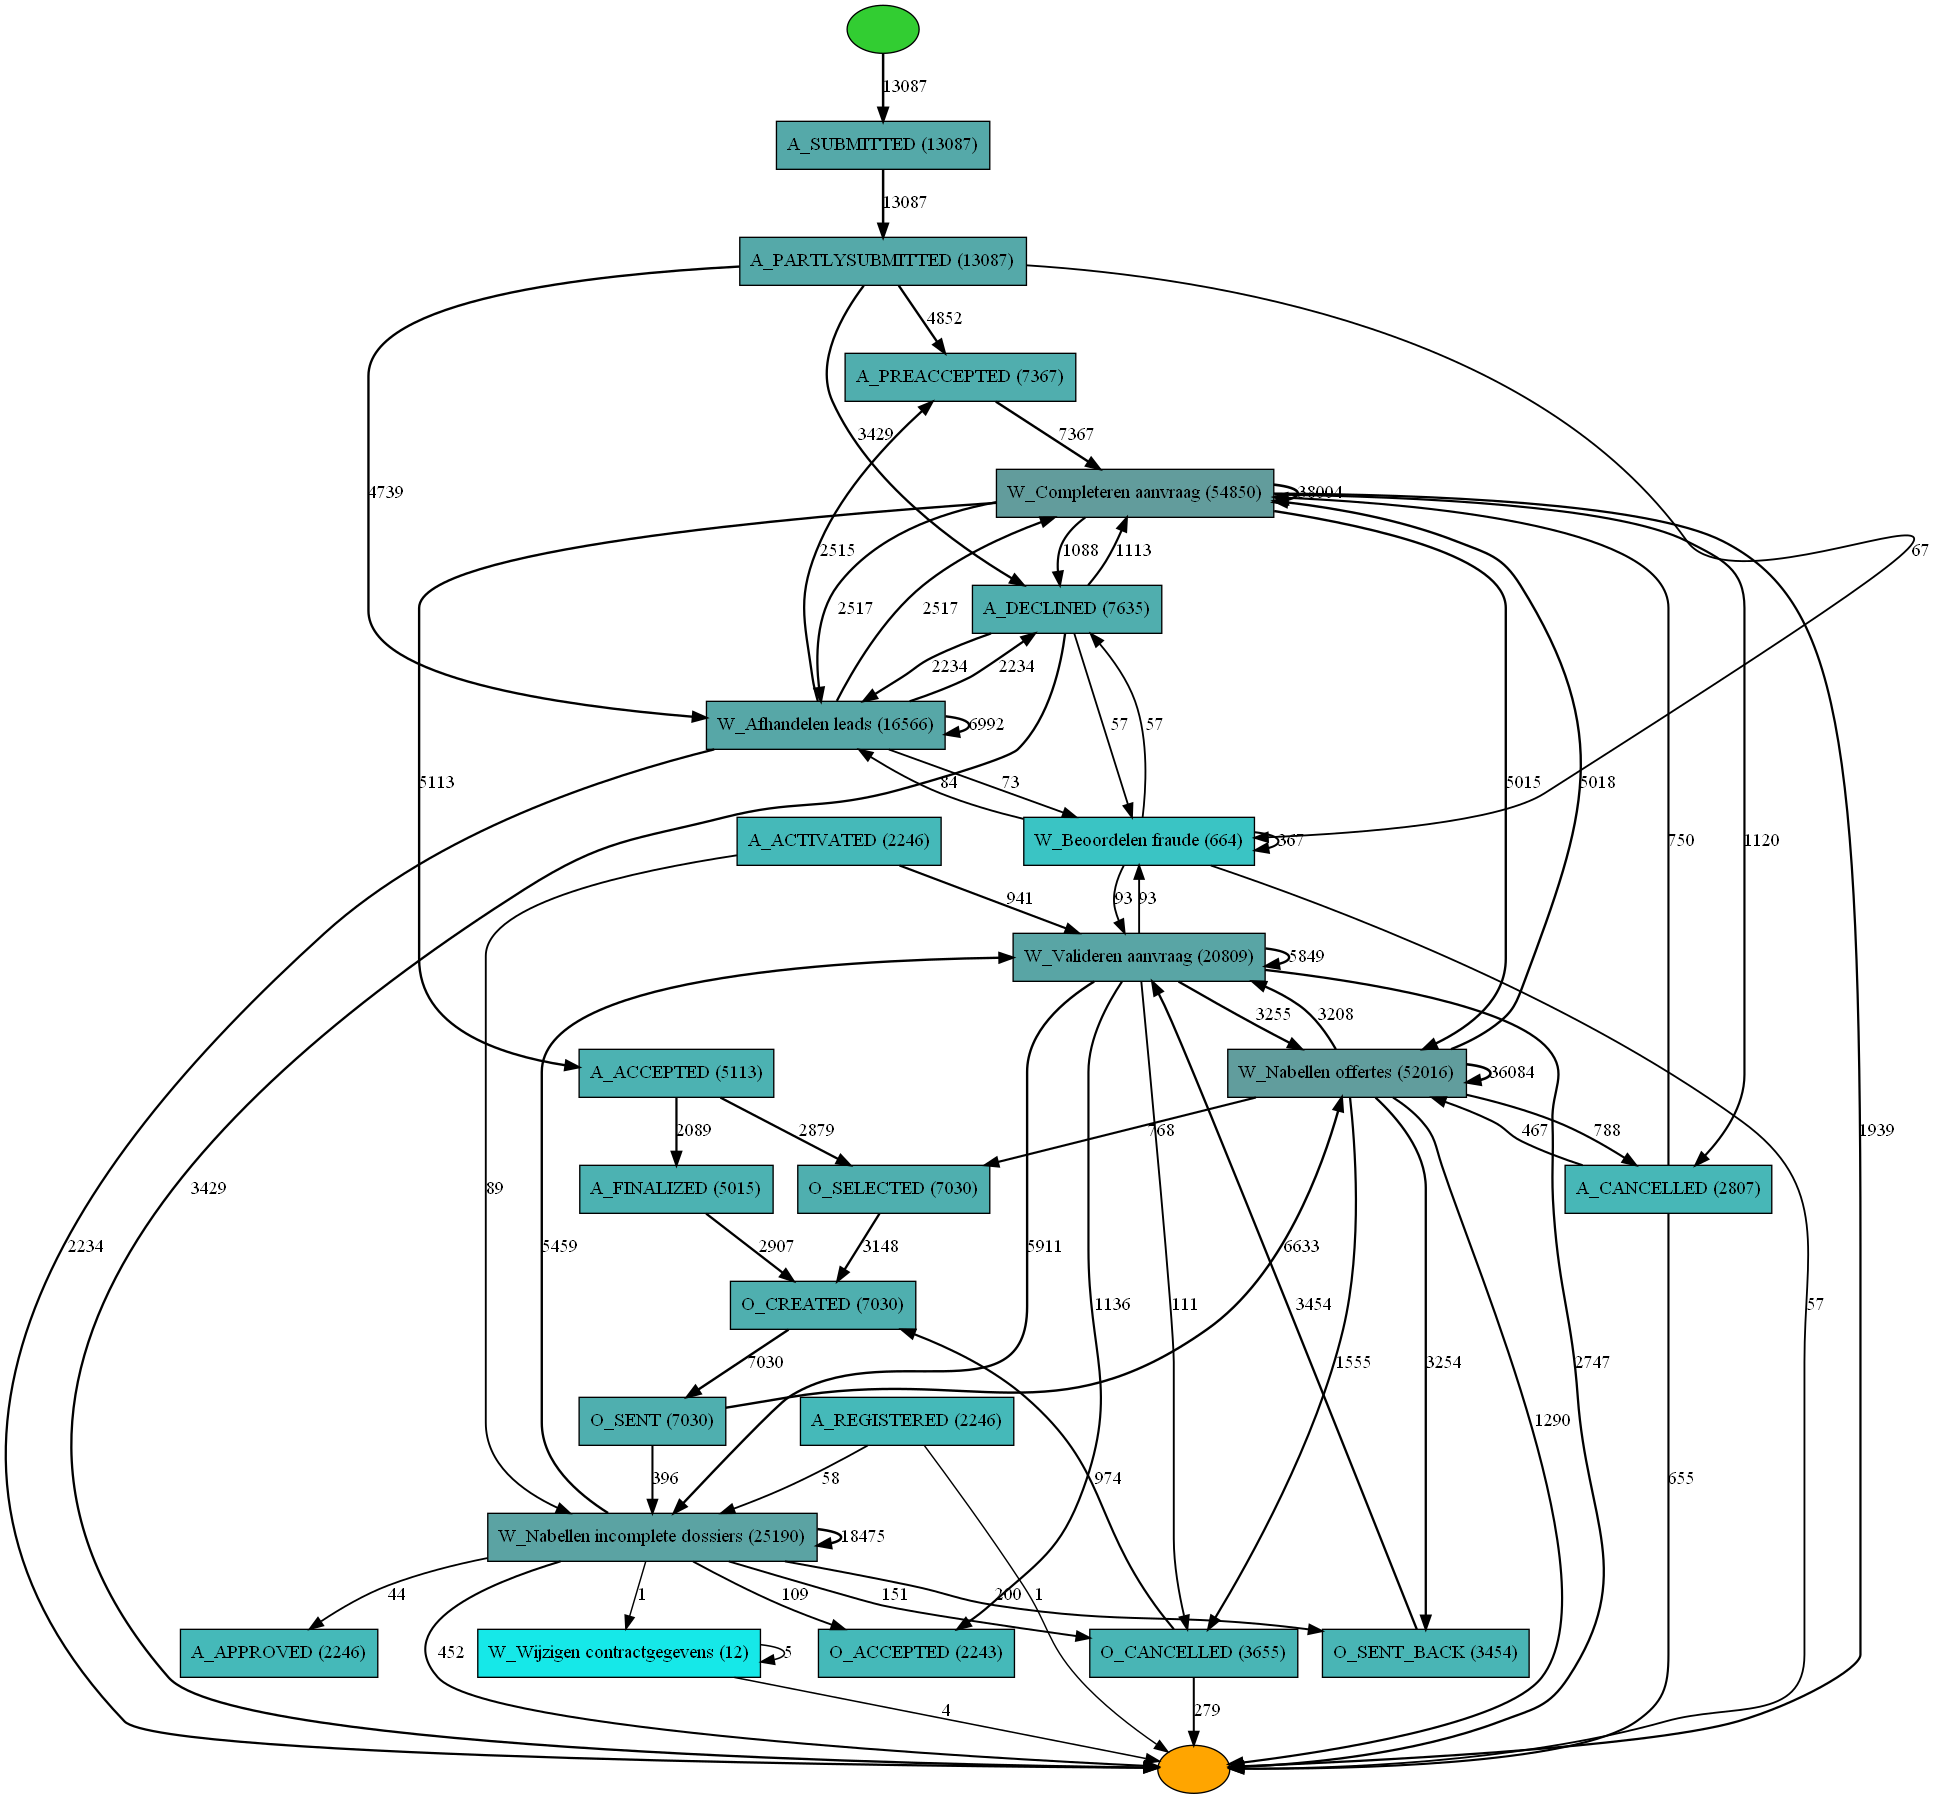

In [10]:
# To have very simple and quick visualization of our process:

heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)


*Before applying any further process mining algorithms, it will be informatives to get some statistics describing our log and the processes, this will helps us in knowing what to look for*

**Q1**: will start by understanding how many variants we have? how many cases in each variant?

*For terminology and definitions please refer to line 3*

In [11]:
variants = variants_filter.get_variants(log)
print(f"We have:{len(variants)} variants/traces in our log")

We have:4366 variants/traces in our log


In another word, we lend or process our loan in 4366 different end-to-end way

**Q2**: Let's try to understand how many cases or loans do those variants have?

In [12]:
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
variants_count[:5] ## Printing the top 5 variants by case number


[{'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,A_DECLINED', 'count': 3429},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,A_DECLINED,W_Afhandelen leads',
  'count': 1872},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,W_Afhandelen leads,W_Afhandelen leads,A_DECLINED,W_Afhandelen leads',
  'count': 271},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,A_PREACCEPTED,W_Completeren aanvraag,W_Afhandelen leads,W_Completeren aanvraag,A_DECLINED,W_Completeren aanvraag',
  'count': 209},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,W_Completeren aanvraag,A_DECLINED,W_Completeren aanvraag',
  'count': 160}]

So out of 13087 loans, 3429 were directly declined (first trace), the second most common path our loans took has 1872 in it.

**Will convert the log into normal dataframe for ease of manipulation**

In [13]:
df_log = pm4py.convert_to_dataframe(log)
df_log.head(3)

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000


In [14]:
df_copy = df_log.copy()

In [15]:
import pandas as pd
from datetime import datetime as dt
import pytz
from dateutil import parser

df_copy['time:timestamp'] = pd.to_datetime(df_copy['time:timestamp'], utc=True)
df_copy['time:timestamp'] = df_copy['time:timestamp'].dt.tz_convert(None)

In [16]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case/loan:
case_starts_ends = df_copy.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']}) 
case_starts_ends = case_starts_ends.reset_index() 
case_starts_ends.columns = ['case:concept:name', 'case_end', 'case_start'] 
case_starts_ends['caselength'] = case_starts_ends['case_end'] - case_starts_ends['case_start'] 
case_starts_ends['caselength_m'] = round(case_starts_ends['caselength'].dt.total_seconds()/60)

# Merge back with the main event log data so that for each row we have the start and end times.
df_copy = df_copy.merge(case_starts_ends, on='case:concept:name') 

# Calculate the relative time by subtracting the process start time from the event timestamp
df_copy['relativetime'] = df_copy['time:timestamp'] - df_copy['case_start']

# Convert relative times to more friendly measures
## seconds
df_copy['relativetime_s'] = df_copy['relativetime'].dt.seconds + 86400 * df_copy['relativetime'].dt.days 
## days
df_copy['relativedays'] = df_copy['relativetime'].dt.days

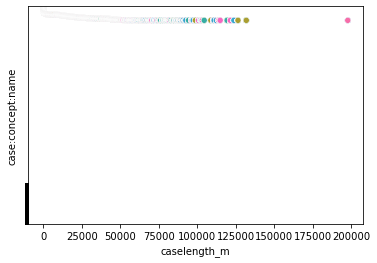

In [22]:
## Get an array of patient labels for the y axis - for graph labelling purposes
loannum = [int(e) for e in df_copy['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Order by the case length
ordered = df_copy.sort_values(by=['caselength', 'case:concept:name', 'caselength_m'])
ax = sns.scatterplot(x=ordered['caselength_m'], y=ordered['case:concept:name'], hue=ordered['concept:name'], legend=False) 
plt.yticks(np.arange(min(loannum), max(loannum)+1, 5)) 
plt.show()

The plan was to perform dotted chart (each dot represents a single event/loan process action). The Y axis will be loan applications number (like in picture below) and x-axis will be length in seconds. This method is very usefull to get better feel for the distribution of process durations (big picture of the length of applications process over our entire populations). And to get an idea of the event flow over absolute time, e.g. if loan applications are coming in regularl timeframe or there is seasonality in it, if there are weekly or daily trends...etc

**Example**

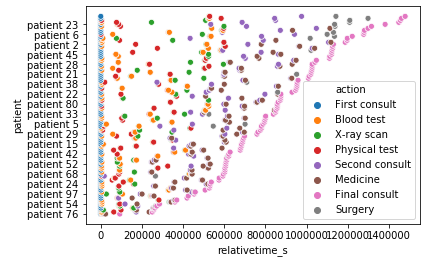



**We'll filter on just few application for demonstration purposes**

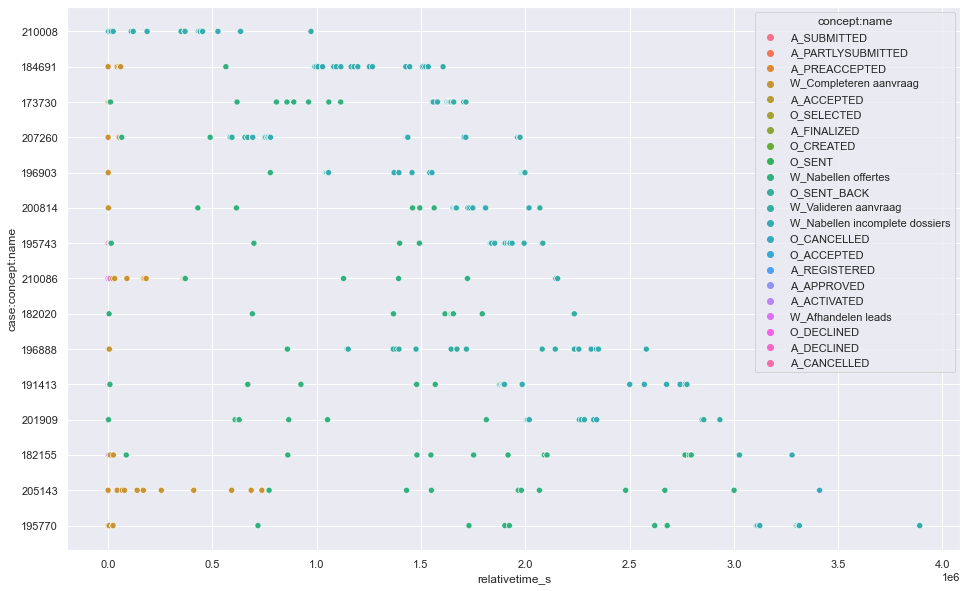

In [18]:
list_applications = ['195743', '196903', '205143','182020','182155','184691','207260','210086','201909','210008','173730','191413','200814','195770','196888']
df_small = df_copy[df_copy['case:concept:name'].isin(list_applications)]


## Get an array of patient labels for the y axis - for graph labelling purposes
loannum = [int(e) for e in df_small['case:concept:name'].apply(lambda x: x.strip('case:concept:name'))]
## Order by the case length
ordered = df_small.sort_values(by=['caselength', 'case:concept:name', 'relativetime_s'])
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['case:concept:name'], hue=ordered['concept:name']) 
#plt.yticks(np.arange(min(loannum), max(loannum)+1, 5))
sns.set(rc={'figure.figsize':(16,10)})
plt.show()


*We'll perform the dotted chart analysis on resources to analys their tasks, and the hiring pattern*

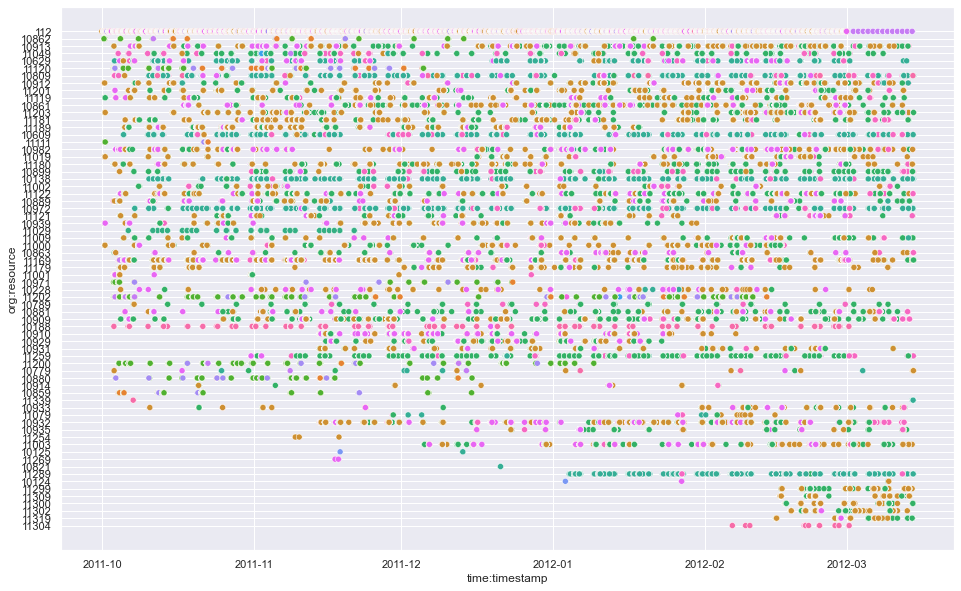

In [19]:
ax = sns.scatterplot(x=df_copy['time:timestamp'], y=df_copy['org:resource'], hue=df_copy['concept:name'], legend=False)

When visualizing resources we see interesting picture (the y axis is resource name/number, x-axis is time), some resources are specialized (because they perform only specific tasks like 11289) others are new and do only few tasks (bottom part of chart like 11309, 11300, 11304). Some resources are like swiss army knife they perform several tasks (top part of chart) those are very crucial to the process.

**Let's return to our log**

During the analysis we saw how complex our process log is. It make sense as next step to:
- Remove the unqualified loans 3429 which were declined directly (we're considering them unqualified for the sake of this analysis, however in real life a detailed discussion with process expert is needed to evaluate whether they're needed or not)
- visualize qualified log (9658 application)
- Simplifying the Event Log by removing redundant steps: For the purposes of this analysis, an event is considered redundant if it occurs concurrently with or subsequently after another event, such that the time between the two events is minimal (a few seconds at best) with respect to the time frame of the case as a whole.
- Determining Standard Case Flow (this might require robust process mining tool)

In [20]:
get_sorted_paths_list(get_paths_from_log(log))

[['W_Completeren aanvraag,W_Completeren aanvraag', 38004],
 ['W_Nabellen offertes,W_Nabellen offertes', 36084],
 ['W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers', 18475],
 ['A_SUBMITTED,A_PARTLYSUBMITTED', 13087],
 ['A_PREACCEPTED,W_Completeren aanvraag', 7367],
 ['O_CREATED,O_SENT', 7030],
 ['W_Afhandelen leads,W_Afhandelen leads', 6992],
 ['O_SENT,W_Nabellen offertes', 6633],
 ['W_Valideren aanvraag,W_Nabellen incomplete dossiers', 5911],
 ['W_Valideren aanvraag,W_Valideren aanvraag', 5849],
 ['W_Nabellen incomplete dossiers,W_Valideren aanvraag', 5459],
 ['W_Completeren aanvraag,A_ACCEPTED', 5113],
 ['W_Nabellen offertes,W_Completeren aanvraag', 5018],
 ['W_Completeren aanvraag,W_Nabellen offertes', 5015],
 ['A_PARTLYSUBMITTED,A_PREACCEPTED', 4852],
 ['A_PARTLYSUBMITTED,W_Afhandelen leads', 4739],
 ['O_SENT_BACK,W_Valideren aanvraag', 3454],
 ['A_PARTLYSUBMITTED,A_DECLINED', 3429],
 ['W_Valideren aanvraag,W_Nabellen offertes', 3255],
 ['W_Nabellen offertes,O_SENT_BAC

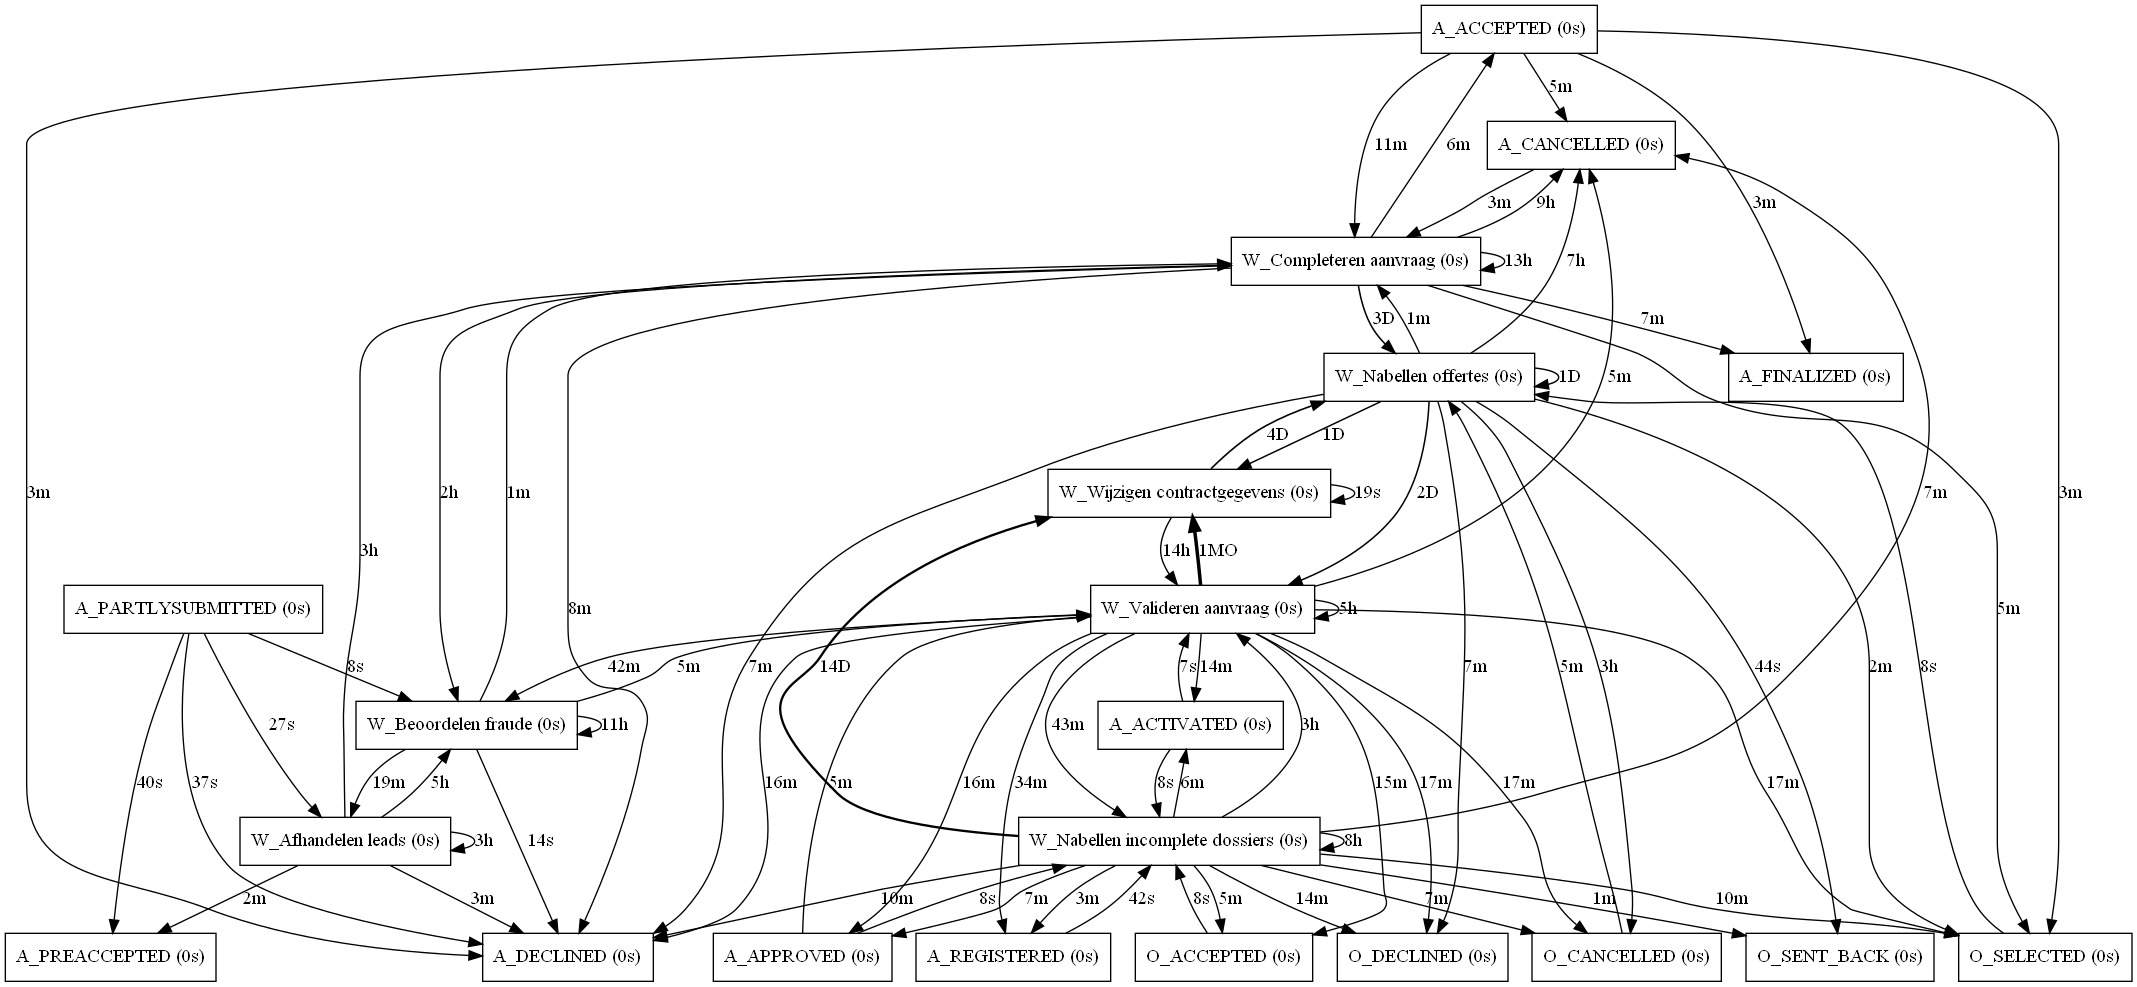

In [21]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

The above is interesting since several observations can be made (from both the time process flow and path analyser):
- All our 13087 loan applications go through A_PARTLYSUBMITTED stage, which makes it redundant so we can safely remove it
- So much rework detected in:
    - "W_Completeren aanvraag": 38004 times the status changes in system without the loan/case moving forward
    - "W_Nabellen offertes": 36004 times the status changes in system without the loan/case moving forward
    - "W_Afhandelen leads" and "A_DECLINED" 2234 times the system status looped over and over without moving forward
- few candidates for further eliminations are:
    - "O_SELECTED" and "O_CREATED" Both in quick succession prior to O_SENT for the 5,015 cases selected to receive offers
    - "O_ACCEPTED","A_REGISTERED" and "A_ACTIVATED" All three occur, in random order, with A_APPROVED for the 2,246 successful applications
    - "O_CANCELLED" and "O_DECLINED" which occur simultaneously with "A_CANCELLED" and "A_DECLINED" respectively

All these redundant events occur within a few seconds of each other and I believe different sequences represent variations in how employees mark these events in the workflow/system. With this in mind, removing this redundancies will not impact the overall process analysis.

**Removing the above and then visualizing the results**

In [22]:
filtered_log1 = variants_filter.apply(log, {'A_SUBMITTED,A_PARTLYSUBMITTED,A_DECLINED'}, parameters={variants_filter.Parameters.POSITIVE: False})
event_log1 = pm4py.convert_to_event_stream(filtered_log1)

print("The count of loan applications left after removing unqualified ones: " , len(filtered_log1))
print("with total number of actions/events: ", len(event_log1))

The count of loan applications left after removing unqualified ones:  9658
with total number of actions/events:  251913


This is already a reduction of 26.2% in number of applications processed, and only 3.9% reduction in actions. No removing the redundant activities discussed above:

In [23]:
filtered_log2 = pm4py.filtering.filter_event_attribute_values(filtered_log1,'concept:name', 
                                                              {"O_SELECTED", "O_CREATED", "O_ACCEPTED",
                                                               "A_REGISTERED", "A_ACTIVATED",
                                                               "O_CANCELLED", "O_DECLINED", 'A_PARTLYSUBMITTED'},
                                                             level='event', retain=False)

In [24]:
event_log2 = pm4py.convert_to_event_stream(filtered_log2)
variants2 = variants_filter.get_variants(filtered_log2)
print("The number of applications under analysis are still: ", len(filtered_log2))
print("However our gain is reduction the of complexity by reducing number of actions/events to: ", len(event_log2))
print("And a reduction in number of traces/variants to: ",len(variants2))

The number of applications under analysis are still:  9658
However our gain is reduction the of complexity by reducing number of actions/events to:  217003
And a reduction in number of traces/variants to:  3345


Removing the unqualified loan applications (i.e applications were rejected directly) and redundant tasks/actions has already given us many benifits. The number of applications went down from 13087 to 9658 (-26.2%), the amount of actions or steps these applications were reduced from 262,200 to 217,003 (-17.2%) and most importantly it reduced the variations of the paths (traces) these loan can take from 4366 to 3345 (-23.4%).

The variant complexity could be further reduced by interviewing process experts at the bank to help further consolidate events/actions that co-occur together and sequencing variations which are not critical for business analysis.

we can try to visualize our process to check the effect of reduction visualy:

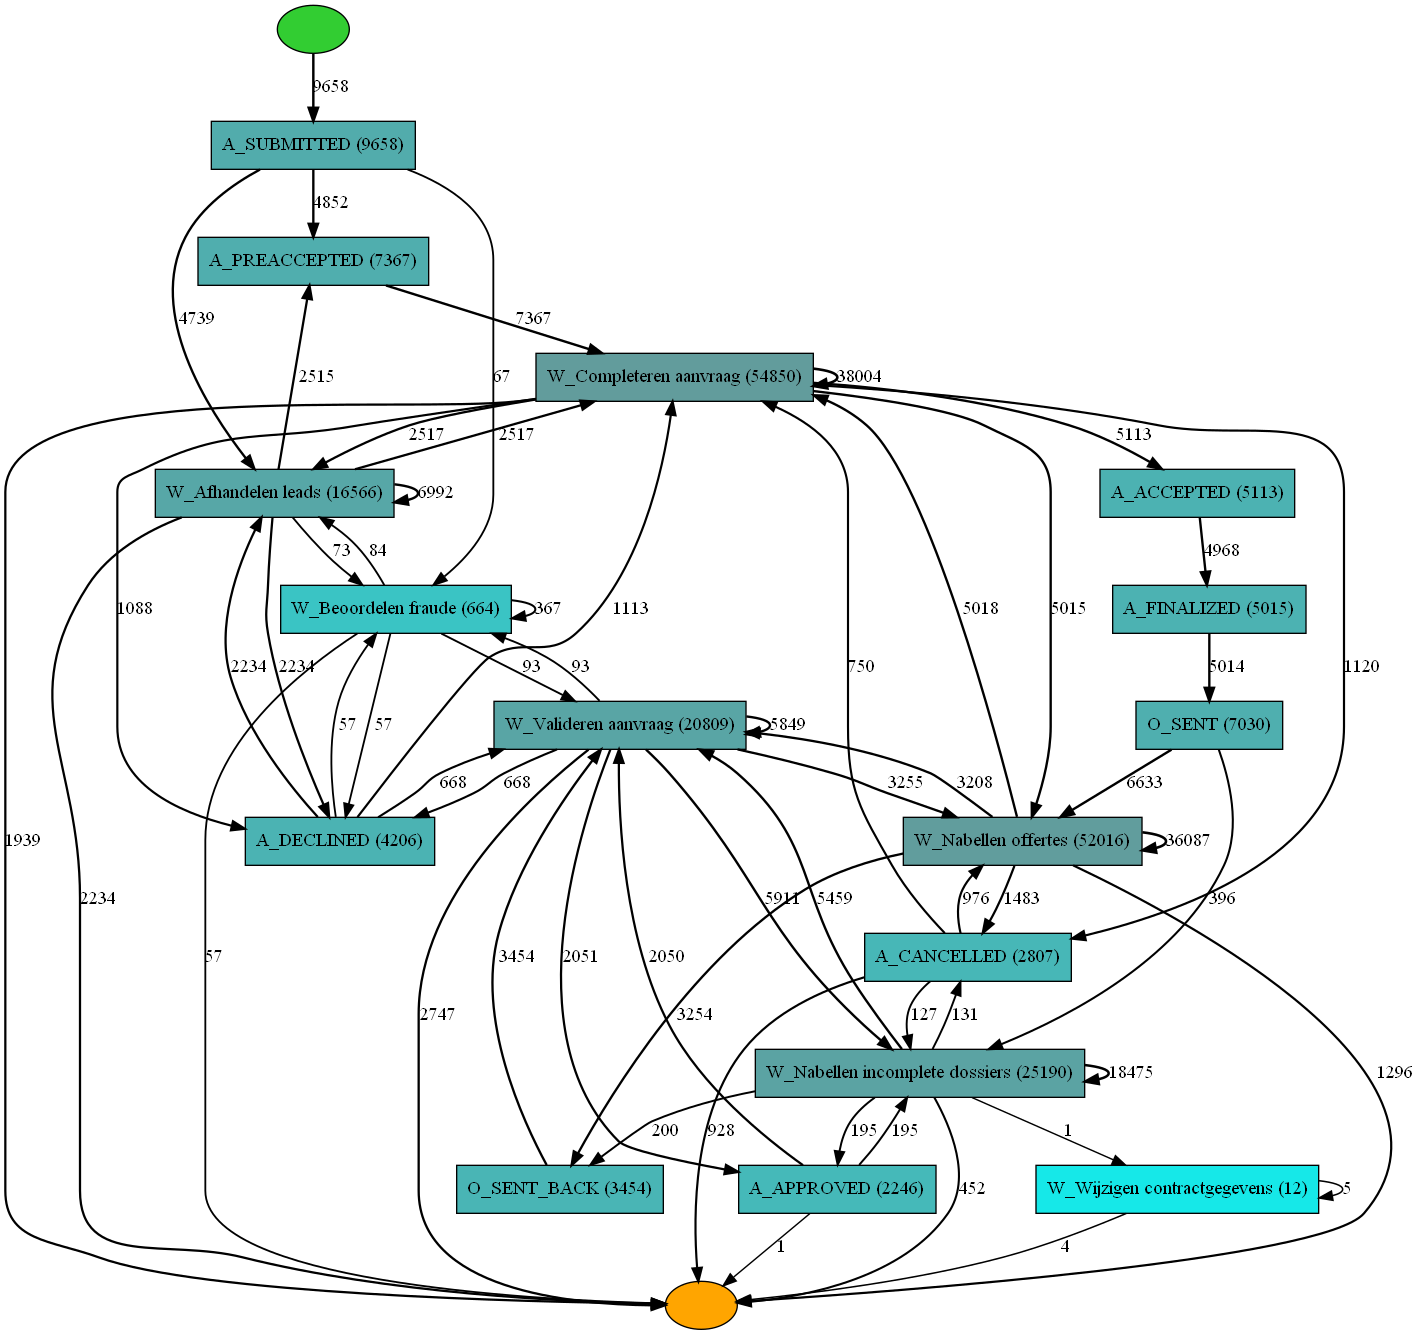

In [25]:
# To have very simple and quick visualization of our process:

heu_net = heuristics_miner.apply_heu(filtered_log2, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

This looks much cleaner and can certainly spot many further needed optimizations, like 195 applications looping between "W_Nabellen incomplete dossiers, O_SENT_BACK", same thing for the 668 loans looped between "A_DECLINED, W_Valideren aanvraag"....etc but as we said this will require interviewing process experts to understand more these steps

**Determining Standard Case Flow**:

In [31]:
#accepted_loan_log = pm4py.filtering.filter_end_activities(filtered_log2,{'A_APPROVED'}, retain=True)
accepted_loan_log = pm4py.filtering.filter_event_attribute_values(filtered_log2,'concept:name', 
                                                              {"A_APPROVED"}, level='case', retain=True)

print("The number of loans were eventually approved: ", len(accepted_loan_log))

The number of loans were eventually approved:  2246


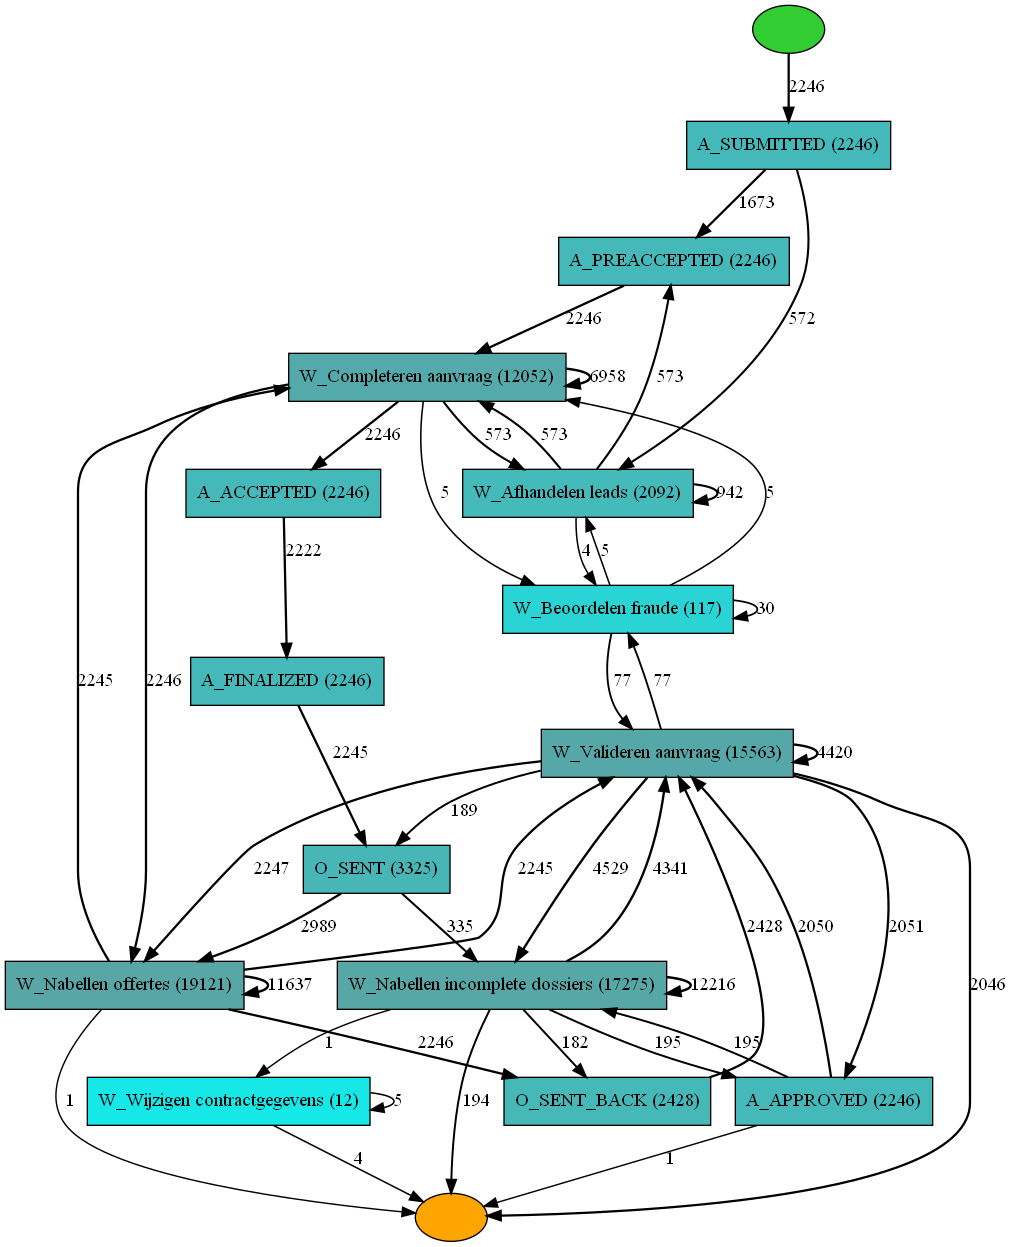

In [27]:
heu_net = heuristics_miner.apply_heu(accepted_loan_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Although there is many ifs and buts in appoved loans, still we can see some sort of high level process:
1. A_SUBMITTED
2. A_PREACCEPTED
3. Completeren aanvraag
4. A_ACCEPTED
5. A_FINALIZED
6. A_FINALIZED
7. O_SENT
8. Nabellen offertes
9. O_SENT BACK
10. Valideren aanvraag
11. A_APPROVED

Of course this is not definit process - but just my initial screened one 

Reading through the documentation of the data and other participants analysis we can conclude/define the endpoints of any loan as follow:
- Approved: Applications that are approved and where customer has accepted the bank’s offer are considered a success and are tagged as Approved, with the end point being depicted by the event A_APPROVED.
- Cancellation: The application is cancelled by the Bank (presumably based on set rules) or at the request of the customer (customer did not like the offer or changed her/his mind). Cancelled applications have a final endpoint of A_CANCELLED.
- Denial: The applicant, after having been subject to review, is deemed unfit to receive the requested loan or overdraft. Denied applications have a final endpoint of A_DECLINED

For that we see in our unfiltered log:
- 13087 starting number of applications
- 3429 were declined imediately 
- 2246 finally approved
- As per documentation we have only 400 cases unresolved at the time of data extraction 
- That leave us with ~7014 loan were either declined or cancelled (over several steps as in process flow down)

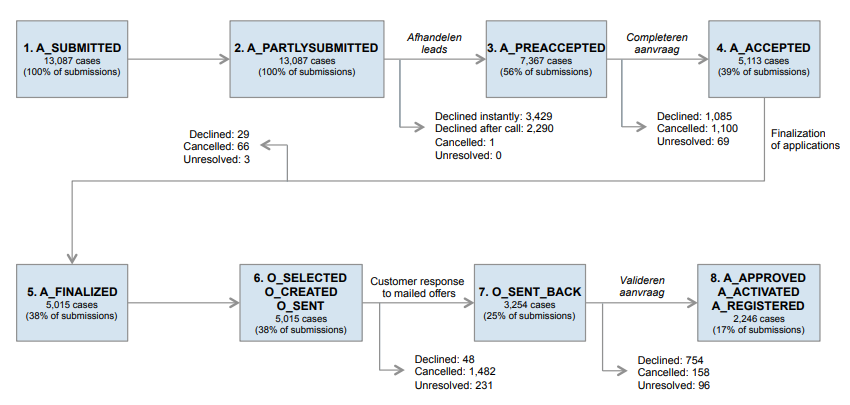

## Social Network Analysis
**Handover of Work**:

The Handover of Work metric measures how many times an individual is followed by another individual in the execution of a business process

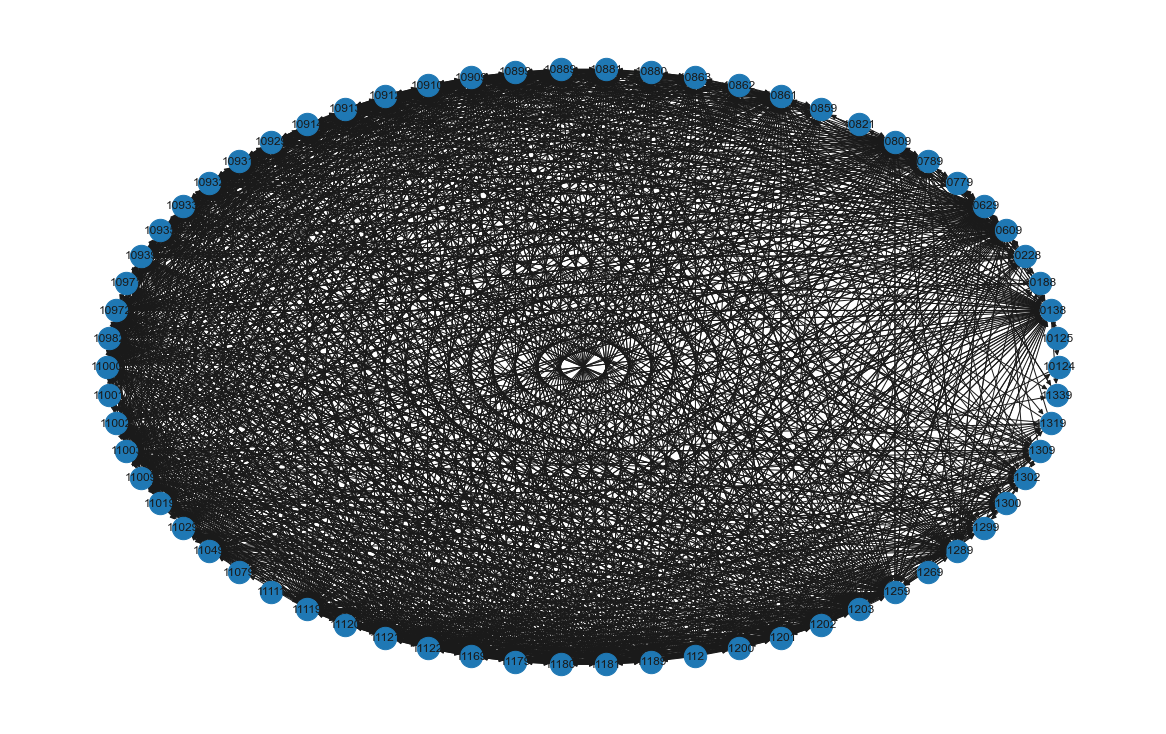

In [32]:
hw_values = sna.apply(accepted_loan_log, variant=sna.Variants.HANDOVER_LOG)
gviz_hw_py = sna_visualizer.apply(hw_values, variant=sna_visualizer.Variants.NETWORKX)
sna_visualizer.view(gviz_hw_py, variant=sna_visualizer.Variants.NETWORKX)

In [51]:
case_arrival_ratio_accepted = case_arrival.get_case_arrival_avg(accepted_loan_log, parameters={
    case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})

case_arrival_ratio = case_arrival.get_case_arrival_avg(filtered_log2, parameters={
    case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})

In [53]:
print("Case arrival ratio for all cases: ",case_arrival_ratio)
print("Case arrival ratio for accepted cases: ",case_arrival_ratio_accepted)

Case arrival ratio for all cases:  1360.0033398570986
Case arrival ratio for accepted cases:  5844.033572828508


In [50]:
all_case_durations = case_statistics.get_all_casedurations(accepted_loan_log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
min(all_case_durations)

708.375

In [55]:
enriched_log_accepted = interval_lifecycle.assign_lead_cycle_time(accepted_loan_log)

In [62]:
enriched_log_accepted[0][0]

{'org:resource': '112', 'concept:name': 'A_SUBMITTED', 'start_timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), '@@duration': 0.0, '@@approx_bh_partial_cycle_time': 0, '@@approx_bh_partial_lead_time': 0, '@@approx_bh_overall_wasted_time': 0, '@@approx_bh_this_wasted_time': 0, '@approx_bh_ratio_cycle_lead_time': 1}

In [44]:
!jupyter nbconvert --to html final_version_personal_loan.ipynb

[NbConvertApp] Converting notebook final_version_personal_loan.ipynb to html
[NbConvertApp] Writing 2578765 bytes to final_version_personal_loan.html
